# Customer Clustering for E-Commerce
### This project uses K-Means clustering algorithm to segment e-commerce customers into distinct groups based on their purchasing behavior. The goal is to provide data-driven insights that can be used to develop targeted marketing strategies, improve customer retention, and optimize service offerings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

In [2]:
df=pd.read_csv('2B.tsv',sep='\t')
df

,Customer ID,Gender,Birth Date,Married,Dependents,Number of Dependents,Country,City,Number of Referrals,Tenure in Months,...,Avg Monthly GB Download,Premium Tech Support,Streaming Movies,Streaming Music,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Refunds,Satisfaction Score
0,8779-QRDMV,Male,1946/07/17,No,No,0,United States,Los Angeles,0,1,...,8,No,Yes,No,Month-to-Month,Yes,Bank Withdrawal,39.65,0.00,3
1,7495-OOKFY,Female,1950/11/12,Yes,Yes,1,United States,Los Angeles,1,8,...,17,No,No,No,Month-to-Month,Yes,Credit Card,80.65,0.00,3
2,1658-BYGOY,Male,1953/03/21,No,Yes,3,United States,Los Angeles,0,18,...,52,No,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,45.61,2
3,4598-XLKNJ,Female,1946/03/08,Yes,Yes,1,United States,Inglewood,1,25,...,12,No,Yes,No,Month-to-Month,Yes,Bank Withdrawal,98.50,13.43,2
4,4846-WHAFZ,Female,1944/04/02,Yes,Yes,1,United States,Whittier,1,37,...,14,No,No,No,Month-to-Month,Yes,Bank Withdrawal,76.50,0.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,Female,1994/08/14,No,No,0,United States,Landers,0,72,...,0,No,No,No,Two Year,Yes,Bank Withdrawal,21.15,19.31,5
7039,6840-RESVB,Male,1986/10/31,Yes,Yes,2,United States,Adelanto,1,24,...,24,Yes,Yes,Yes,One Year,Yes,Mailed Check,84.80,48.23,3
7040,2234-XADUH,Female,1994/12/30,Yes,Yes,2,United States,Amboy,4,72,...,59,No,Yes,Yes,One Year,Yes,Credit Card,103.20,45.38,4
7041,4801-JZAZL,Female,1992/12/15,Yes,Yes,2,United States,Angelus Oaks,1,11,...,17,No,No,No,Month-to-Month,Yes,Bank Withdrawal,29.60,27.24,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Birth Date                         7043 non-null   object 
 3   Married                            7043 non-null   object 
 4   Dependents                         7043 non-null   object 
 5   Number of Dependents               7043 non-null   int64  
 6   Country                            7043 non-null   object 
 7   City                               7043 non-null   object 
 8   Number of Referrals                7043 non-null   int64  
 9   Tenure in Months                   7043 non-null   int64  
 10  Avg Monthly Long Distance Charges  7043 non-null   float64
 11  Internet Service                   7043 non-null   objec

# Exploratory Data Analysis

## Drop unnecessary values

To achieve meaningful patterns, redundant column has to be dropped. If a column has no relationship with the customer's behavior or characteristics, not dropping those columns will result in less effective clustering, overfitting, or noisy cluster assignments.

Columns with too many unique values can also lead to unnecessary complexity, which is why if the said column isn't irrelevant, it is advised to drop the column. We will check the columns where we suspected has too many unique value, which is City column.

In [4]:
print("Unique values in City column:")
print(df['City'].unique())
print(f"Number of unique cities: {df['City'].nunique()}")

Unique values in City column:
['Los Angeles' 'Inglewood' 'Whittier' ... 'Topaz' 'Jacumba' 'Holtville']
Number of unique cities: 1106


Because it is confirmed that City column has too many uniqe values, we will drop it. Other irrelevant columns will also with drop, with the reason below:

- **Column ID**: As this column is a unique identifier, it doesn't provide any meaningful information
- **Country**: All of the customers belong to the same country, so it doesn't add value to the clustering process.
- **City**: There are a large number of unique values in this column, introducing unnecessary compexity.

In [5]:
df = df.drop(columns=['Customer ID', 'Country', 'City'])

## Check for unstandardized values

In [6]:
all_value_counts = {col: df[col].value_counts() for col in df.columns}

for col, counts in all_value_counts.items():
    print(f"Value counts for column: {col}")
    print(counts)
    print("\n")


Value counts for column: Gender
Gender
Male      3555
Female    3488
Name: count, dtype: int64


Value counts for column: Birth Date
Birth Date
2004/09/30    5
1973/06/07    5
1980/02/13    4
1966/06/22    4
1963/11/22    4
             ..
1999/10/14    1
1973/02/09    1
1981/04/01    1
1979/12/09    1
1980/11/21    1
Name: count, Length: 6002, dtype: int64


Value counts for column: Married
Married
No     3641
Yes    3402
Name: count, dtype: int64


Value counts for column: Dependents
Dependents
No     5416
Yes    1627
Name: count, dtype: int64


Value counts for column: Number of Dependents
Number of Dependents
0    5416
1     553
2     531
3     517
5      10
4       9
6       3
7       2
8       1
9       1
Name: count, dtype: int64


Value counts for column: Number of Referrals
Number of Referrals
0     3821
1     1086
5      264
3      255
7      248
9      238
2      236
4      236
10     223
6      221
8      213
11       2
Name: count, dtype: int64


Value counts for column: T

After checking, there are no unstandardized value in the columns, so no further standardization is needed.

## Converting Birth Date to Age

In the Birth Date column, we can find the birth dates of each observation. Since our task is to estimate the obesity levels of each individual, Age may be more useful for prediction compared to Birth Date. Age is easier to process in machine learning model, including clustering, as algorithms work more effectively with numerical values rather than date formats. Converting birth date to age may reduce complexity and enhance relevance.

Age might also give more insights to customer behavior, preferences, and needs. For example, older customers might prefer different services than younger ones.

In [7]:
df['Birth Date'] = pd.to_datetime(df['Birth Date'], errors='coerce')
df['Age'] = 2025 - df['Birth Date'].dt.year
df.drop(columns=['Birth Date'], inplace=True)
df

,Gender,Married,Dependents,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Internet Service,Internet Type,Avg Monthly GB Download,Premium Tech Support,Streaming Movies,Streaming Music,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Refunds,Satisfaction Score,Age
0,Male,No,No,0,0,1,0.00,Yes,DSL,8,No,Yes,No,Month-to-Month,Yes,Bank Withdrawal,39.65,0.00,3,79
1,Female,Yes,Yes,1,1,8,48.85,Yes,Fiber Optic,17,No,No,No,Month-to-Month,Yes,Credit Card,80.65,0.00,3,75
2,Male,No,Yes,3,0,18,11.33,Yes,Fiber Optic,52,No,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,45.61,2,72
3,Female,Yes,Yes,1,1,25,19.76,Yes,Fiber Optic,12,No,Yes,No,Month-to-Month,Yes,Bank Withdrawal,98.50,13.43,2,79
4,Female,Yes,Yes,1,1,37,6.33,Yes,Fiber Optic,14,No,No,No,Month-to-Month,Yes,Bank Withdrawal,76.50,0.00,2,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,No,No,0,0,72,22.77,No,NaN,0,No,No,No,Two Year,Yes,Bank Withdrawal,21.15,19.31,5,31
7039,Male,Yes,Yes,2,1,24,36.05,Yes,Cable,24,Yes,Yes,Yes,One Year,Yes,Mailed Check,84.80,48.23,3,39
7040,Female,Yes,Yes,2,4,72,29.66,Yes,Fiber Optic,59,No,Yes,Yes,One Year,Yes,Credit Card,103.20,45.38,4,31
7041,Female,Yes,Yes,2,1,11,0.00,Yes,DSL,17,No,No,No,Month-to-Month,Yes,Bank Withdrawal,29.60,27.24,4,33


To do that, we will first convert Birth Date to Datetime format and then make a new column named Age by substracting year of birth from the year 2025. Next, the birth date column is removed as it is no longer needed.

## Column with Null Values

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Married                            7043 non-null   object 
 2   Dependents                         7043 non-null   object 
 3   Number of Dependents               7043 non-null   int64  
 4   Number of Referrals                7043 non-null   int64  
 5   Tenure in Months                   7043 non-null   int64  
 6   Avg Monthly Long Distance Charges  7043 non-null   float64
 7   Internet Service                   7043 non-null   object 
 8   Internet Type                      5517 non-null   object 
 9   Avg Monthly GB Download            7043 non-null   int64  
 10  Premium Tech Support               7043 non-null   object 
 11  Streaming Movies                   7043 non-null   objec

In [9]:
df['Internet Type'].isnull().values.sum()

1526

As we can see, Internet Type column has 1526 null values. We are going to impute the null values.

### Internet Type

Usually, null values are often imputed with mode, median, or mean. But in this case, we will impute null values at Internet Type with 'No Internet'.

In [10]:
internet_null = df[df['Internet Type'].isnull()]
internet_null

,Gender,Married,Dependents,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Internet Service,Internet Type,Avg Monthly GB Download,Premium Tech Support,Streaming Movies,Streaming Music,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Refunds,Satisfaction Score,Age
25,Male,Yes,No,0,1,11,29.54,No,NaN,0,No,No,No,Month-to-Month,No,Mailed Check,19.95,0.00,1,80
41,Female,No,No,0,0,8,27.95,No,NaN,0,No,No,No,Month-to-Month,No,Bank Withdrawal,19.65,0.00,2,75
199,Female,No,No,0,0,1,22.92,No,NaN,0,No,No,No,Month-to-Month,Yes,Bank Withdrawal,19.45,0.00,1,71
373,Male,No,No,0,0,1,19.87,No,NaN,0,No,No,No,Month-to-Month,No,Credit Card,20.05,0.00,1,70
375,Female,Yes,No,0,1,1,22.86,No,NaN,0,No,No,No,Month-to-Month,Yes,Credit Card,20.85,0.00,3,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7026,Female,No,No,0,0,51,19.23,No,NaN,0,No,No,No,Two Year,No,Bank Withdrawal,20.65,19.32,3,26
7027,Female,No,No,0,0,39,1.57,No,NaN,0,No,No,No,Two Year,No,Mailed Check,20.15,25.92,3,31
7028,Male,Yes,Yes,1,2,12,25.33,No,NaN,0,No,No,No,Month-to-Month,Yes,Bank Withdrawal,19.20,45.46,3,40
7034,Female,No,No,0,0,2,6.85,No,NaN,0,No,No,No,Month-to-Month,Yes,Mailed Check,20.05,0.00,3,58


The reason why is because when we look at rows with nan values at Internet Type columns, it is shown that all of them also doesn't have internet service, and doesnt have any data on average monthly GB download. This is why reaching a conclusion that rows with null values at Internet Type values should be replace with 'No Internet' as it provides real insight rather than using the mode.

In [11]:
df['Internet Type'].fillna("No Internet", inplace=True)

In [12]:
df.isnull().sum()

Gender                               0
Married                              0
Dependents                           0
Number of Dependents                 0
Number of Referrals                  0
Tenure in Months                     0
Avg Monthly Long Distance Charges    0
Internet Service                     0
Internet Type                        0
Avg Monthly GB Download              0
Premium Tech Support                 0
Streaming Movies                     0
Streaming Music                      0
Contract                             0
Paperless Billing                    0
Payment Method                       0
Monthly Charge                       0
Total Refunds                        0
Satisfaction Score                   0
Age                                  0
dtype: int64

After imputing null values, the checking shows all columns have no null values.

# INSPECTION

## Distribution

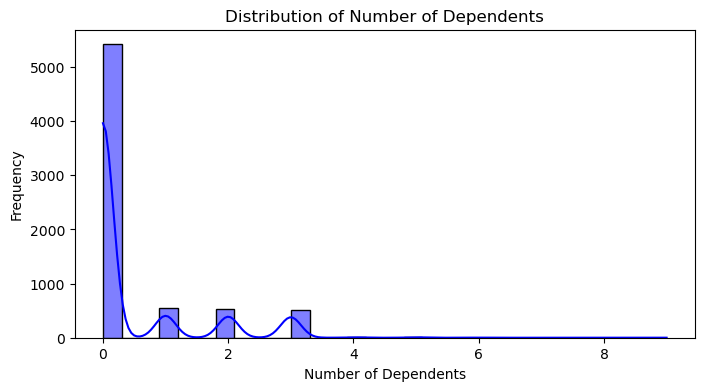

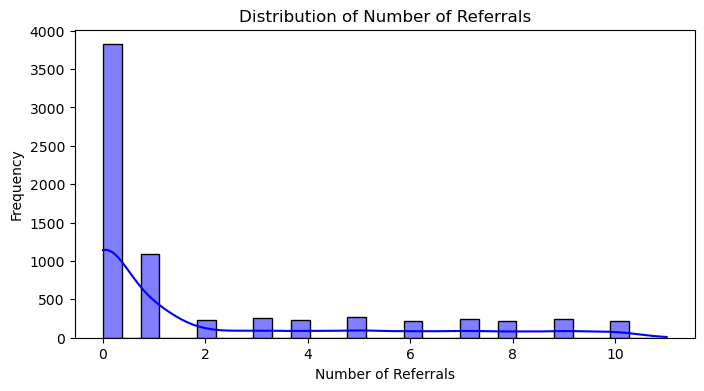

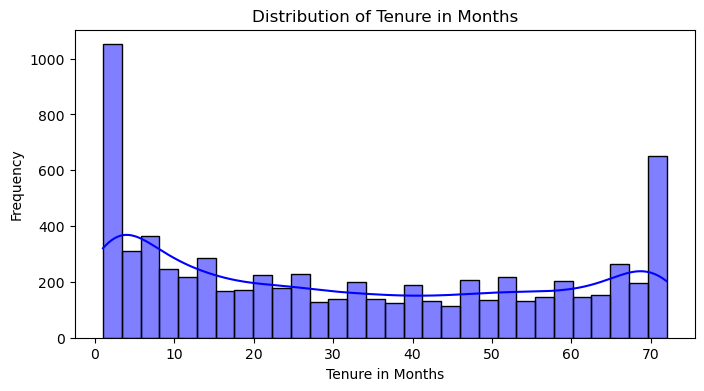

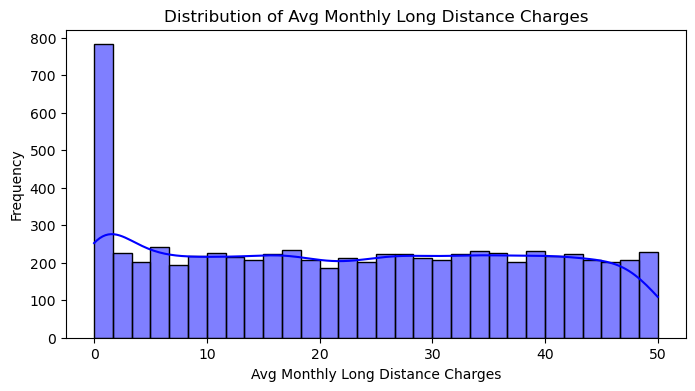

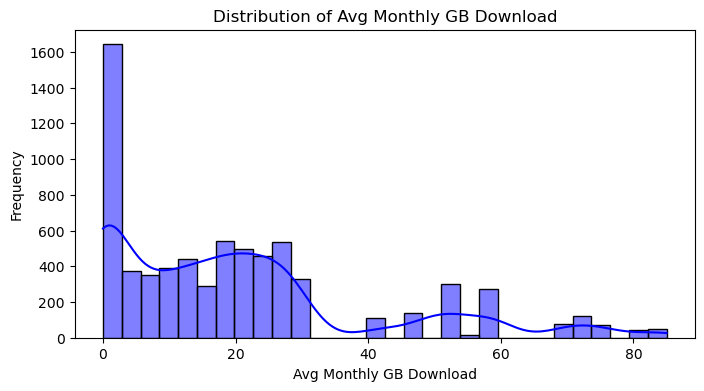

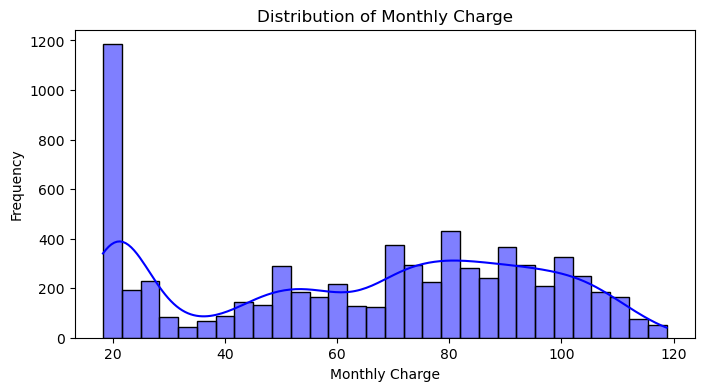

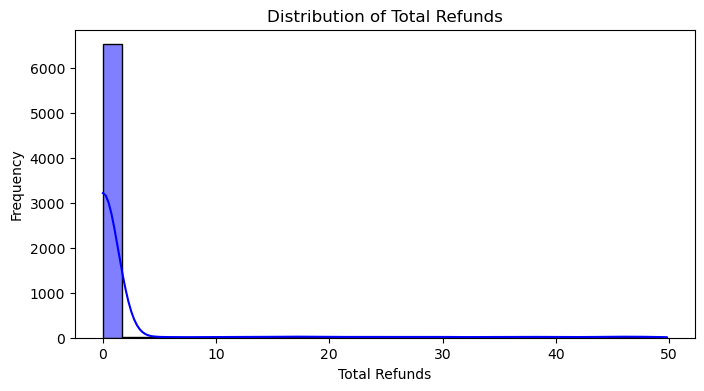

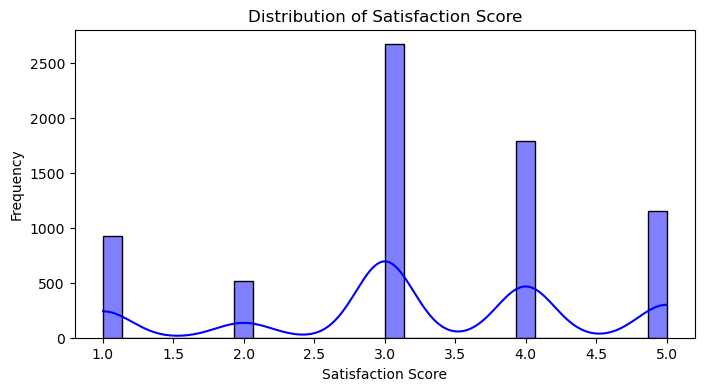

In [13]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

As we can see from the chart, there are a skewness and outliers in the data. But actually, we do not need to be transform it as K-Means is primarily affected by scaling and distance rather than distribution shapes.

For example, in the Total Refunds column, the distinction between zero refunds and non-zero refunds may be critical for understanding customer behavior or clustering outcomes, as refund behavior can directly affects how customers are grouped.

## Encoding and Scaling

Although transformation is not needed, encoding and scaling is crucial.

### Encoding

Clustering algorithms like K-Means requre numerical data to work. Encoding transforms categorical features into numerical representations so the model can process them. Without encoding, algorithms may misinterpret categorical data as ordinal or fail to process it altogether.

We are going to use **One Hot** to encode the categorical data. The reason why is because the categorical values are treated as distinct entities without introducing ordinality. One Hot is more preferred rather than Label Encoding as LE can imply an ordinal relationship which may mislead the algorithm.

### Scaling

Different features may have different scales, for example monthly charges is in hundreds and tenure in single digits. Features with larger ranges can dominate distance calculations in algorithms like K-Means. This is where scaling comes in as scaling standardizes all features to bring them to a comparable range, ensuring that each feature contributes equally to the clustering process.

We are going to use **StandardScaler** to scale the numerical data. The reason why is because it ensures numerical features are on the same scale, which is crucial for distance-based algorithms like K-Means. It also retains the distribution shape of the data, as the clustering process has to reflect the original data's structure. On the other hand, MinMax scaler is sesitive to outliers, which can distort the rangem it also does not preserve original distribution, which is why it is nor preferred to use in this case.

In [14]:
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Standardize numerical columns
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_columns)  # One-hot encode categorical columns
    ]
)

df_preprocessed = preprocessor.fit_transform(df)

encoded_columns = list(numerical_columns) + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns))
df_preprocessed = pd.DataFrame(df_preprocessed, columns=encoded_columns)

df = df_preprocessed.copy()

C:\Users\N3N0C\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Fine Tuning

We are going to fine tune the number of clusters and evaluate it using **Elbow Method** and **Silhouette Score**. Fine tuning is needed to ensure that the clusters are well-separated, cohesive, and interpretable. Choosing the number of clusters directly impacts the insights derived from clustering. Selecting the wrong amount might result to misleading results. Too many clusters may cause over-segmentation where clusters may overlap or contain very few data points, making them impractical, where too few clusters can fail to capture the diversity or nuances in the data, resulting in overly broad groupings.

## Elbow Method

Elbow Method evaluates the inertia, sum of squared distances between data points and their cluster centers, for different numbers of clusters. The optimal number of clusters is identified at the "elbow point" of the curve, where the decrease in inertia slows significantly.

## Silhouette Score

The Silhouette Score measures how well each data point fits within its assigned cluster compared to other clusters, with scores ranging from -1 to 1. A score close to 1 indicates well-separated and compact clusters, a score close to 0 suggests overlapping clusters, and a negative score indicates that points may be misclassified.The optimal number of clusters is chosen where the score is highest.

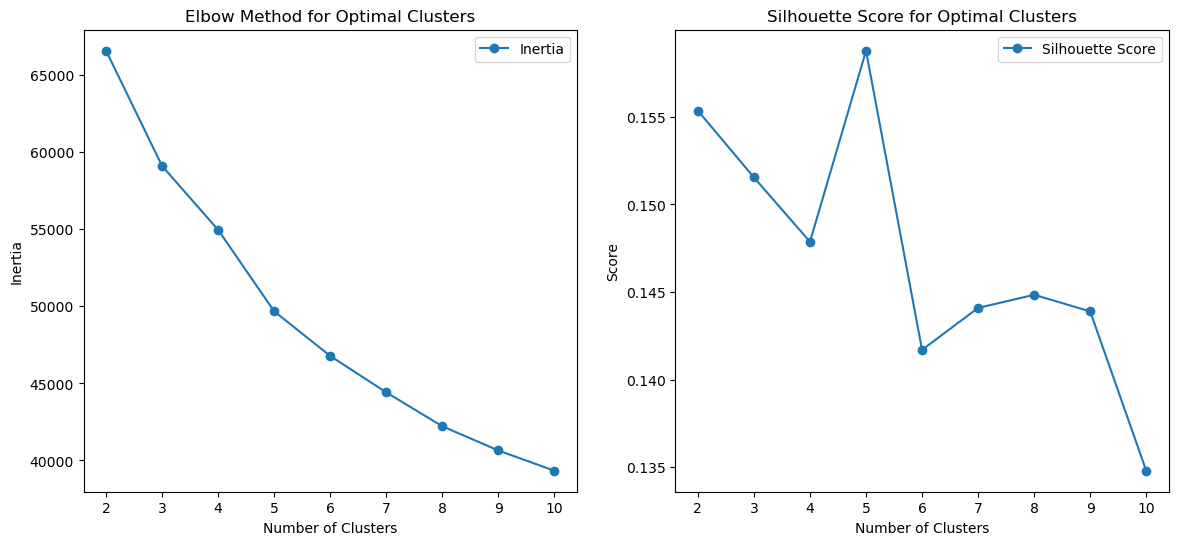

In [15]:
cluster_range = range(2, 11)
inertia = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df)
 
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df, cluster_labels))

plt.figure(figsize=(14, 6))

#Elbow Method
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o', label='Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()

#Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()

From the result, we can see that the elbow point appears around 4 clusters. The silhouette score is highest at 5 clusters. However, the score at 4 clusters is also reasonably high, which aligns well with the Elbow Method. While the 2 clusters scores second highest in the silhouette, it might lead to overly broad grouping.

While 5 clusters might provide slightly better-defined clusters it could introduce additional complexity. Choosing 4 clusters is a more reasonable choice as it balances compactness (Elbow Method) and separability (Silhouette Score).

# Model Training

In [16]:
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(df)

## Cluster Visualization

### Scatter Plot

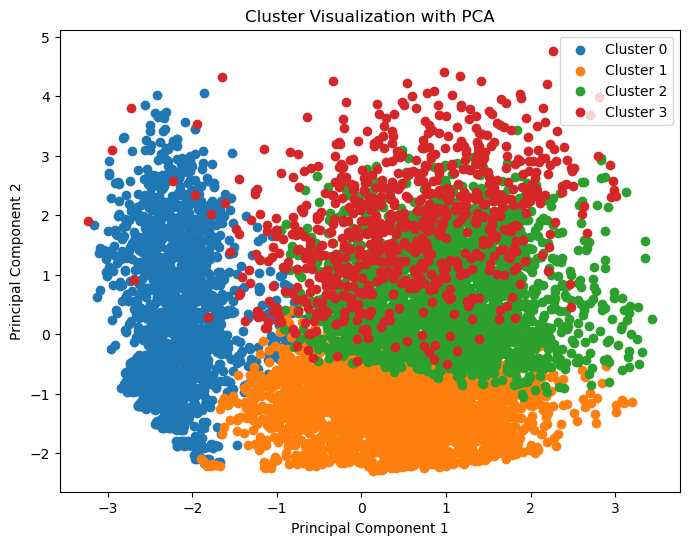

In [17]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.drop('Cluster', axis=1))

plt.figure(figsize=(8, 6))
for cluster in range(4):
    plt.scatter(
        pca_result[df['Cluster'] == cluster, 0],
        pca_result[df['Cluster'] == cluster, 1],
        label=f'Cluster {cluster}'
    )

plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


The clusters show a moderate degree of separation in the reduced two-dimensional space, indicating that the features used for clustering effectively group the data into distinct categories.

### Cluster Distribution

In [18]:
print("Cluster Distribution:")
print(df['Cluster'].value_counts())

Cluster Distribution:
Cluster
1    2606
2    2042
0    1631
3     764
Name: count, dtype: int64


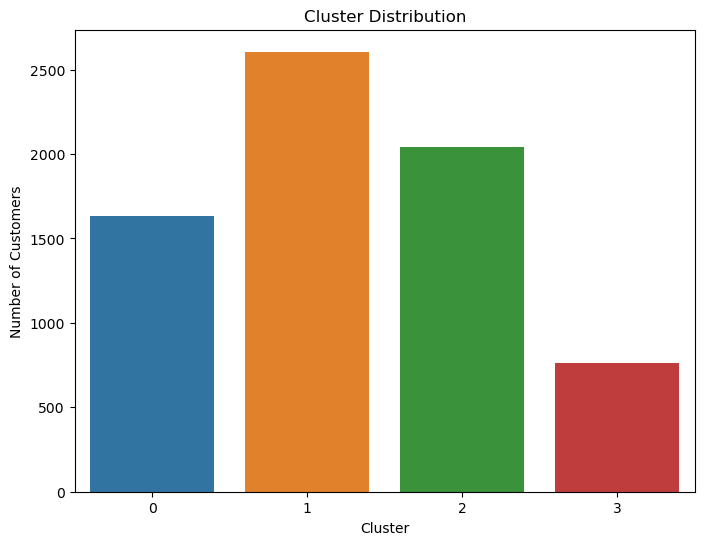

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=df)
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

The most dominant cluster is Cluster 1, followed by Cluster 2, 0, and 3.

# Cluster Character Analyzation

## Cluster Mean

In [20]:
print("Cluster Characteristics:")
print(df.groupby('Cluster').mean())

Cluster Characteristics:
         Number of Dependents  Number of Referrals  Tenure in Months  \
Cluster                                                                
0                    0.237905             0.064460         -0.091588   
1                   -0.433425            -0.530213         -0.742508   
2                   -0.395274             0.349752          0.906247   
3                    2.027004             0.736134          0.306020   

         Avg Monthly Long Distance Charges  Avg Monthly GB Download  \
Cluster                                                               
0                                 0.065260                -0.960923   
1                                -0.061972                 0.169032   
2                                 0.069154                 0.178318   
3                                -0.112763                 0.998222   

         Monthly Charge  Total Refunds  Satisfaction Score  Gender_Male  \
Cluster                                 

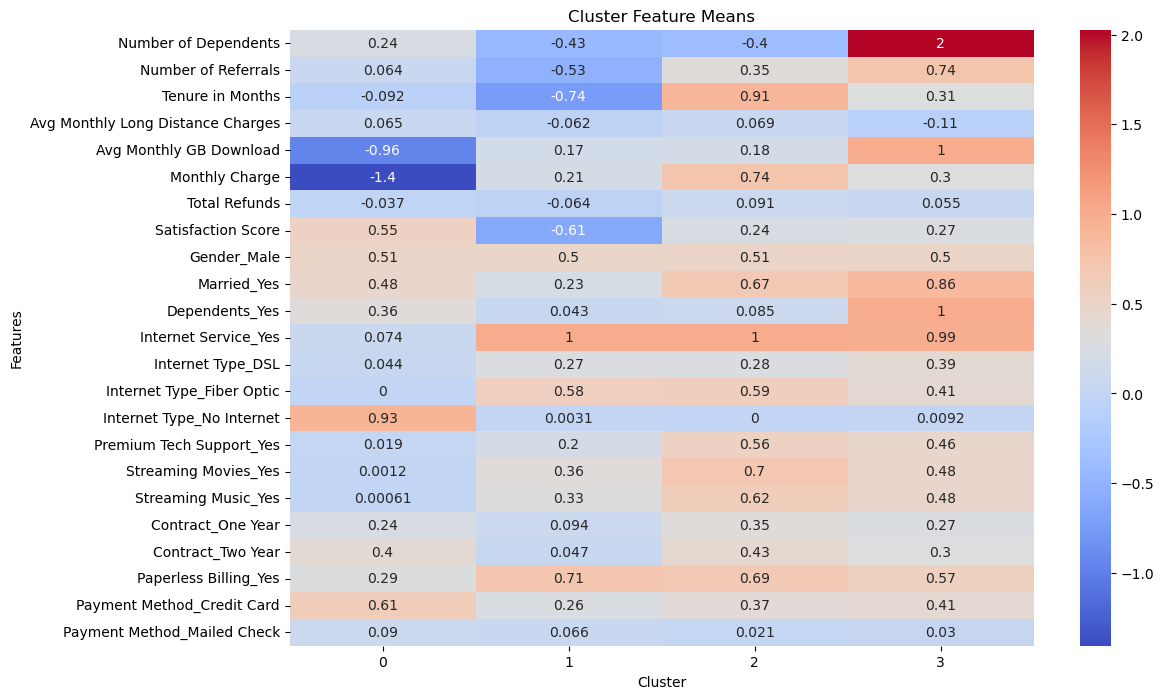

In [21]:
cluster_means = df.groupby('Cluster').mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, cmap='coolwarm', annot=True)
plt.title('Cluster Feature Means')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.show()

Values of cluster mean represents the average value of each feature within a cluster. By analyzing these means, we can identify key characteristics of each cluster. For example, a cluster with a high mean for Monthly Charge might represent high-paying customers. A low mean for Tenure might indicate a cluster of new customers.

### Cluster 0's Character

From the output, 92.6% of customers in this cluster have no internet service, and this reflects in their Monthly Charge being the lowest among all clusters (-1.41), likely because these customers don't subscribe to internet-related services. Their average monthly GB download is also low (-0.96), and they almost dont use streeaming services (Streaming Movies_Yes = 0.001 and Streaming Music_Yes = 0.0006). These reflects non-internet users. But Cluster 0 is loyal as suggesred by higher proportion on Two-Year Contracts (40.3%).


**ACTION**

Cluster 0 is considered as non-internet minimal users. We need to focus on upselling internet services to these customers by promoting affordable bundles or introductory internet plans, while also highlight benefits of streaming services and internet features to convert them into higher-value customers.

For introducing internet services, we can offer introductory internet plans with discounted rates for the first 6 months to incentivize adoption. To increase streaming service usage, we can offer free access to basic streaming services for the first few months upon subscribing to internet plans. As these clusters might be new to internet service, we need implify the process of upgrading to internet services by providing free installation and setup assistance.

### Cluster 1's Character

Cluster 1 has the lowest tenure (-0.74), indicating new or short-term customers. They are also has the lowest satisfaction score (-0.61), suggesting dissatisfaction. Their engagement is low (low streaming activity).

**ACTION**

Cluster 1 is considered to be dissatisfied short-term users. To help knowing what to improve, we can use targeted surveys to identify the reasons behind dissatisfaction, such as pricing, service quality, or technical issues. Incentives like discounts or small credits can also convince people to complete the survey. To improve streaming service use, free or discounted access to streaming services for the first 3-6 months can be offered to this cluster.

### Cluster 2's Character

Cluster 2 has the  longest tenure (0.91), indicating they are loyal, long-term customers. They are also moderately satisfied (0.23 on Satisfaction Score) and are among the highest-value customers, with the highest monthly charge (0.73). This cluster is the most engaged in streaming, as shown by the high usage of Streaming Movies (0.702) and Streaming Music (0.615), and they also actively utilize Premium Tech Support (55.5%). Overall, they represent a profitable, loyal segment with significant engagement in value-added services.

**ACTION**

Cluster 2 is considered engaged, loyal, long-term users. We need to retain high-value customers. A way to do it is to reward loyalty through VIP memberships, priority customer support, or access to premium content as a reward for their loyalty. This segment is also useful to build brand advocacy. We can encourage these loyal customers to refer new users by offering rewards such as bill credits or free service months for successful referrals. We can cross-sell or upsell additional premium services like enhanced streaming or faster internet plans for more profit. Also, premium tech support has to be mantained.

### Cluster 3's Character

Cluster 3 has the highest number of dependents (2.03), suggesting family-oriented customers. They also actively refer others, shown by being the highest score on number of referrals (0.74), indicating satisfied customers who actively refer others. This cluster has a high usage of streaming movies and music, reflected in their above average monthly charge (0.30)

**ACTION**

Cluster 3 is considered to be family-oriented engaged users, In order to retain these cluster of customers, we can create affordable family-oriented bundles and introduce multi-device streaming options for households with multiple users. We can utilize referrals by providing additional benefits for referrals, such as free months of service, bill credits, or exclusive perks. Also, streaming offerings strength has to be mantained and  family-friendly service enhancements.